# Baseline SVM for Dutch tweets

Tutorial code support: https://www.youtube.com/watch?v=M9Itm95JzL0&t=2704s


In [16]:
import pandas as pd
import numpy as np 
from sklearn import svm #model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #bag of words vectorization
import gensim
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import pickle
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sn

**1. Get training & test data**

In [2]:
def read_csv(filename, sheetname='sheet'): 
    """
    Reads excel file containing training data and 
    assigns tweets and labels as x or y variable values.
    """
    df = pd.read_excel(open(filename, 'rb'),
               sheet_name=sheetname) 
    x = df.values[:,0]
    y = df.values[:,1]
    
    
    return x, y

#change sheetname to 'gold-emotion' for emotion training labels
#change sheetname to 'gold-proactivity' for binary proactivity training labels 
x_train, y_train = read_csv('gold.xlsx', 'gold-polarity') 

#change sheetname to 'test-data-emotion' for emotion test labels
#change sheetname to 'test-data-proactivity' for binary proactivity test labels
x_test, y_test = read_csv('gold.xlsx', 'test-data-polarity') 

len(x_test)
len(x_train)


899

**2. Count distribution of labels for training**

In [3]:
df = pd.read_excel(open('gold.xlsx', 'rb'),
               sheet_name='gold-polarity')
df['polarity'].value_counts()

neutral     362
positive    269
negative    268
Name: polarity, dtype: int64

**3. Preprocessing**

In [4]:
def preprocessing2(tweets):
    """
    Program to preprocess data ready for system input. 
    Removes stopwords.
    Returns each tweet as a list of word sequences using the keras 
    preprocessing module 'text_to_word_sequence'
    
    Preprocessing code inspired by: Saitej Dandge Feb 13, 2019. 
    https://github.com/saitejdandge/Sentimental_Analysis_LSTM_Conv1D/blob/master/main.py
    """
    dutch_stop_words = set(stopwords.words('dutch')) #from dutch nltk 
    added_stop_words = set(dutch_stop_words)
    
    for stopword in dutch_stop_words: 
        added_stop_words.add(stopword.replace('\'',''))
        pass
    stopWords=added_stop_words
    punct='\n\t!"#$%&()*+,-./:;<=>?[\]^_`{|}~'
    word_seq=[]
    
    for item in tweets:
        item=str(item)
        item=item.replace('\'', '')
        newl = [x for x in text_to_word_sequence(item,filters=punct, lower=True)] #if not x.startswith("@")]
        filtered_sent = [w for w in newl if not w in stopWords] 
        word_seq.append(filtered_sent)
        pass
    return word_seq
x_train_sequences = preprocessing2(x_train)
x_test_sequences = preprocessing2(x_test)

In [7]:
def after_preprocessing(preprocessed_tweets):
    """
    Joins the preprocessed sequences into suitable format for tdf-vectorizer later
    """
    cleaned = []
    for item in preprocessed_tweets:
        joined = [' '.join(item)]
        cleaned.append(joined)
    
    df = pd.DataFrame(cleaned)
    return df
x_train_cleaned = after_preprocessing(x_train_sequences)
x_test_cleaned = after_preprocessing(x_test_sequences)
x_train_real = x_train_cleaned.values[:,0]
x_test_real = x_test_cleaned.values[:,0]


**4. Tf-idf vectorizer**


In [9]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html?highlight=tfidfvectorizer#sklearn.feature_extraction.text.TfidfVectorizer
vectorizer = TfidfVectorizer()
xtrain_vectors = vectorizer.fit_transform(x_train_real)  # returns a matrix 
xtest_vectors = vectorizer.transform(x_test_real)
print(xtrain_vectors.toarray()) #check 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
#print(vectorizer.get_feature_names())
print(xtrain_vectors.shape)

(899, 5237)


**5. Train Linear SVM Model** 

In [12]:
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(xtrain_vectors, y_train)

predicted = clf_svm.predict(xtest_vectors)
print(predicted[:10])

['neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'positive' 'neutral'
 'positive' 'neutral' 'neutral']


**6. EVALUATION**

In [14]:
from sklearn.metrics import classification_report
y_pred = predicted
y_true = y_test
print(classification_report(y_true, y_pred, digits=2))

              precision    recall  f1-score   support

    negative       0.61      0.49      0.55        67
     neutral       0.52      0.78      0.63        69
    positive       0.76      0.50      0.60        62

    accuracy                           0.60       198
   macro avg       0.63      0.59      0.59       198
weighted avg       0.63      0.60      0.59       198



In [18]:
#SAVE OUTPUT TO EXCEL FILE 

zipped = list(zip(x_test, predicted, y_true))
nested_list = [list(item) for item in zipped]
df = pd.DataFrame(nested_list, columns=['tweet','system', 'gold'])
#df.to_excel('SVM-EMOTION-output.xlsx', index=False)


In [20]:
## CONFUSION MATRIX 
## Confusion matrix creation inspired by student Quincy Liem. 

entity_types = ['positive','negative', 'neutral']

def confusion_matrix(gold, system, entity_types):
                
    confusion_matrix = pd.crosstab(pd.Series(gold),
                                   pd.Series(system),
                                   rownames=['True'],
                                   colnames=['Predicted'],
                                   margins=True)
                                   
                                   

    df_cm = pd.DataFrame(confusion_matrix,
                         index = entity_types,
                         columns = entity_types)

    sn.set(font_scale=1.2) #for label size
    plt.figure(figsize=(6,4))
    cm = sn.heatmap(df_cm, annot=True, annot_kws={"size": 12},
                    cmap="YlGnBu")
    # cm.invert_yaxis()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45)
    # plt.title("Confusion matrix\n")
    plt.show()
    

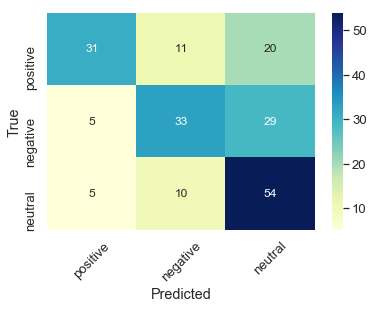

In [22]:
confusion_matrix(df['gold'], df['system'], entity_types)


**End of Notebook**